Import all librarys

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
import scipy
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.utils import load_img, img_to_array
from keras.models import load_model
from keras.optimizers import Adam

Test if tensorflow is using the GPU of our system

In [12]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


# Load the data of the directory

In [13]:
data_dir = "./data/Train/"

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 4070 files belonging to 5 classes.
Using 3256 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 4070 files belonging to 5 classes.
Using 814 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Bathroom', 'Bedroom', 'House Map', 'Kitchen', 'Living Room']


Show a sample of the 9 first images

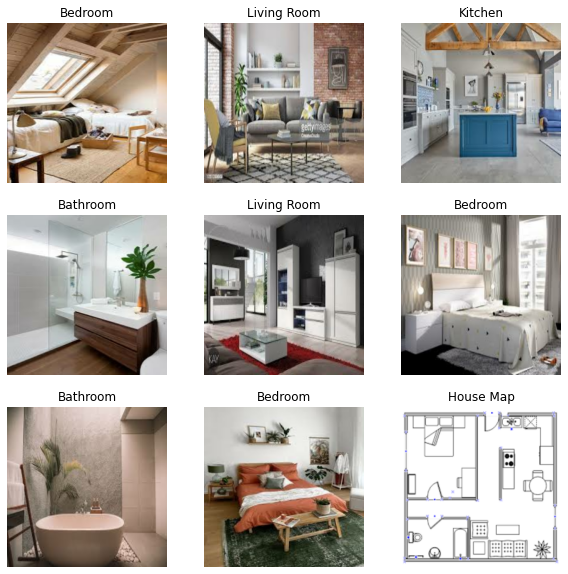

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


# Preprocess data

Scale the image dividing it by 255

In [19]:
normalization_layer = Rescaling(1./255)

In [20]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
normalized_valid_ds = val_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.011127547 1.0


# Train the models

Model trained using convultional neural network

In [21]:
numberOfClass = len(class_names)
def def_conv_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32,(3,3),input_shape = input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(32,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(64,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(numberOfClass)) # output
    model.add(Activation("softmax"))
    return model

In [22]:
conv_model = def_conv_model(input_shape=(256,256,3))

In [23]:
conv_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                    

In [25]:
epochs=20
conv_hist = conv_model.fit(
  normalized_train_ds,
  validation_data= normalized_valid_ds,
  epochs=epochs
)

Epoch 1/20


c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


102/102 [==============================] - 139s 1s/step - loss: 1.5722 - accuracy: 0.3326 - val_loss: 1.3547 - val_accuracy: 0.3747
Epoch 2/20
102/102 [==============================] - 152s 1s/step - loss: 1.2393 - accuracy: 0.4665 - val_loss: 1.1875 - val_accuracy: 0.5049
Epoch 3/20
102/102 [==============================] - 133s 1s/step - loss: 0.9719 - accuracy: 0.6038 - val_loss: 1.1495 - val_accuracy: 0.5455
Epoch 4/20
102/102 [==============================] - 135s 1s/step - loss: 0.7241 - accuracy: 0.7199 - val_loss: 1.2802 - val_accuracy: 0.5553
Epoch 5/20
102/102 [==============================] - 127s 1s/step - loss: 0.4450 - accuracy: 0.8345 - val_loss: 1.3301 - val_accuracy: 0.5921
Epoch 6/20
102/102 [==============================] - 125s 1s/step - loss: 0.2401 - accuracy: 0.9186 - val_loss: 1.6218 - val_accuracy: 0.5762
Epoch 7/20
102/102 [==============================] - 127s 1s/step - loss: 0.1722 - accuracy: 0.9475 - val_loss: 1.9165 - val_accuracy: 0.5774
Epoch 8/20

In [26]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

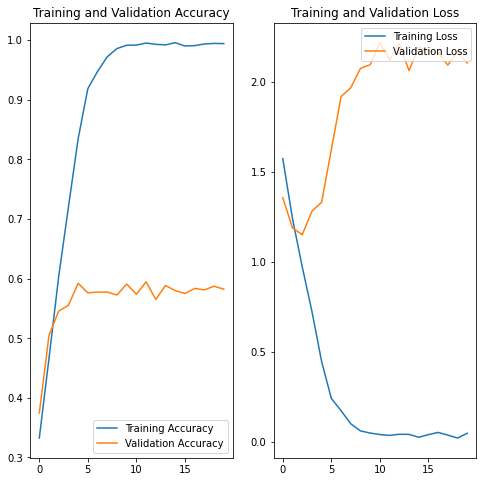

In [27]:
plot_history(conv_hist)

Model with convolutional neural network using image data generator

In [28]:
width_shape = 224
height_shape = 224
num_classes = 5
epochs = 50
batch_size = 32 

In [29]:

train_datagen = ImageDataGenerator( 
    rescale= 1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    validation_split= 0.2)

valid_datagen = ImageDataGenerator(rescale= 1./255, validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "training",
    batch_size= batch_size)

valid_generator = valid_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "validation",
    batch_size= batch_size)


Found 3258 images belonging to 5 classes.
Found 812 images belonging to 5 classes.


In [30]:
print(train_generator.next()[0][1])

[[[0.8623324  0.838803   0.85448927]
  [0.8762349  0.8527055  0.86839175]
  [0.8581724  0.8247935  0.843763  ]
  ...
  [0.81118065 0.7523571  0.7405924 ]
  [0.81118065 0.7523571  0.7405924 ]
  [0.81118065 0.7523571  0.7405924 ]]

 [[0.84809625 0.82456684 0.8402531 ]
  [0.8508263  0.8272969  0.8429832 ]
  [0.8529849  0.81962985 0.83859134]
  ...
  [0.8159604  0.7571368  0.7453721 ]
  [0.8159604  0.7571368  0.7453721 ]
  [0.8159604  0.7571368  0.7453721 ]]

 [[0.84030753 0.8167781  0.8324644 ]
  [0.8367744  0.813245   0.8289313 ]
  [0.85228467 0.8189536  0.8379071 ]
  ...
  [0.8117648  0.75294125 0.7411765 ]
  [0.8117648  0.75294125 0.7411765 ]
  [0.8117648  0.75294125 0.7411765 ]]

 ...

 [[0.78313524 0.77137053 0.8145078 ]
  [0.7211324  0.70649195 0.75058776]
  [0.7697178  0.7477133  0.7871476 ]
  ...
  [0.8117648  0.7960785  0.854902  ]
  [0.8117648  0.7960785  0.854902  ]
  [0.8117648  0.7960785  0.854902  ]]

 [[0.7833182  0.7715535  0.81469077]
  [0.72097325 0.70635664 0.7504446 ]


Plot examples of the images

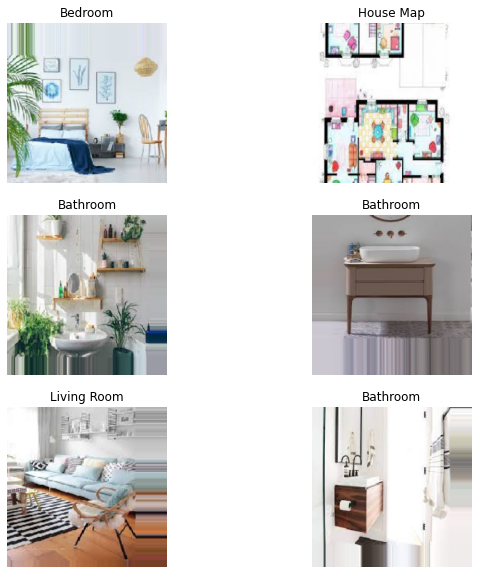

In [31]:
batch =  train_generator.next()
  
plt.figure(figsize=(10, 10))

for i in range(6):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(batch[0][i])
  plt.title(class_names[np.argmax(batch[1][i])])
  plt.axis("off")

In [32]:
model_conv_with_data_gen = def_conv_model(input_shape=(224,224,3))

In [33]:
model_conv_with_data_gen.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'] )

conv_hist_with_data_generator = model_conv_with_data_gen.fit(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

Epoch 1/50
 23/102 [=====>........................] - ETA: 1:14 - loss: 3.1176 - accuracy: 0.2310

c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


102/102 [==============================] - 98s 956ms/step - loss: 1.9057 - accuracy: 0.2723 - val_loss: 1.4560 - val_accuracy: 0.3214
Epoch 2/50
102/102 [==============================] - 96s 942ms/step - loss: 1.4369 - accuracy: 0.3514 - val_loss: 1.4311 - val_accuracy: 0.3966
Epoch 3/50
102/102 [==============================] - 93s 905ms/step - loss: 1.3542 - accuracy: 0.3877 - val_loss: 1.2308 - val_accuracy: 0.4323
Epoch 4/50
102/102 [==============================] - 92s 904ms/step - loss: 1.2679 - accuracy: 0.4334 - val_loss: 1.1991 - val_accuracy: 0.4618
Epoch 5/50
102/102 [==============================] - 92s 904ms/step - loss: 1.2448 - accuracy: 0.4429 - val_loss: 1.2724 - val_accuracy: 0.4532
Epoch 6/50
102/102 [==============================] - 92s 901ms/step - loss: 1.2144 - accuracy: 0.4497 - val_loss: 1.1631 - val_accuracy: 0.5062
Epoch 7/50
102/102 [==============================] - 92s 904ms/step - loss: 1.1741 - accuracy: 0.4834 - val_loss: 1.1395 - val_accuracy: 0.5

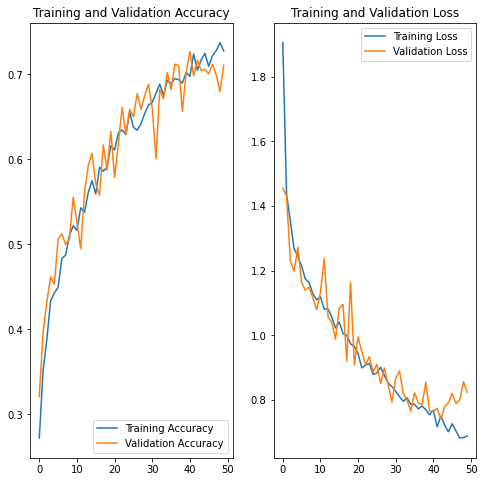

In [34]:
plot_history(conv_hist_with_data_generator)

### Model using transfer learning techniche with MobileNetV2 layers

In [35]:
numberOfClass = len(class_names)

In [36]:
base_model=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
x = Dropout(0.5)(x)
preds=Dense(numberOfClass,activation='softmax')(x) #final layer with softmax activation

In [37]:
transfer_learning_model=Model(inputs=base_model.input,outputs=preds)

In [38]:
for i,layer in enumerate(transfer_learning_model.layers):
  print(i,layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [39]:
for layer in transfer_learning_model.layers[:-6]:
    layer.trainable=False

In [40]:
transfer_learning_model.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'] )

transfer_learning_hist = transfer_learning_model.fit_generator(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

C:\Users\danie\AppData\Local\Temp\ipykernel_18968\689159174.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_hist = transfer_learning_model.fit_generator(train_generator,


Epoch 1/50
102/102 [==============================] - 97s 931ms/step - loss: 0.6899 - accuracy: 0.7449 - val_loss: 0.4438 - val_accuracy: 0.8313
Epoch 2/50
102/102 [==============================] - 92s 902ms/step - loss: 0.4146 - accuracy: 0.8511 - val_loss: 0.3812 - val_accuracy: 0.8534
Epoch 3/50
102/102 [==============================] - 91s 892ms/step - loss: 0.4146 - accuracy: 0.8496 - val_loss: 0.3924 - val_accuracy: 0.8534
Epoch 4/50
102/102 [==============================] - 90s 878ms/step - loss: 0.3818 - accuracy: 0.8656 - val_loss: 0.3523 - val_accuracy: 0.8547
Epoch 5/50
102/102 [==============================] - 86s 842ms/step - loss: 0.3629 - accuracy: 0.8705 - val_loss: 0.3615 - val_accuracy: 0.8805
Epoch 6/50
102/102 [==============================] - 85s 832ms/step - loss: 0.3261 - accuracy: 0.8785 - val_loss: 0.2981 - val_accuracy: 0.8879
Epoch 7/50
102/102 [==============================] - 93s 912ms/step - loss: 0.3245 - accuracy: 0.8791 - val_loss: 0.3456 - val_ac

KeyboardInterrupt: 

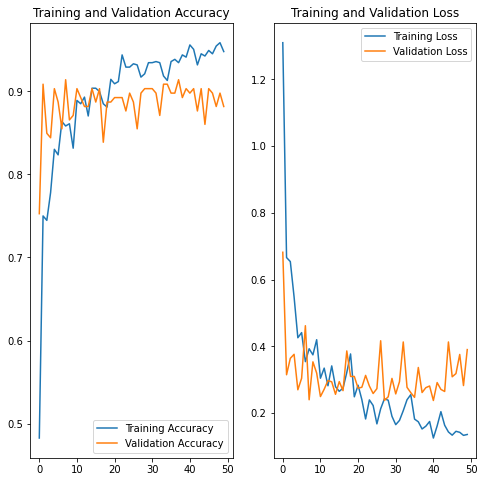

In [ ]:
plot_history(transfer_learning_hist)

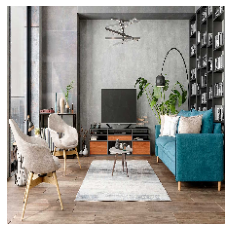

1/1 [==============================] - 1s 630ms/step
The prediction is Living Room


In [ ]:
def load_image(img_path, show=False):


    img = load_img(img_path, target_size=(width_shape, height_shape))
    img_tensor =    img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.  
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\salon1.jpeg'
new_image = load_image(img_path,show=True)

pred = transfer_learning_model.predict(new_image)

print(f'The prediction is {class_names[np.argmax(pred)]}')


In [ ]:
transfer_learning_model.save("./Models/model_transfer_learning/model_transfer_learning.h5",overwrite=True)

In [ ]:
transfer_learning_model = load_model('Models\model_transfer_learning\model_transfer_learning.h5')

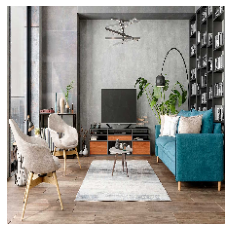

1/1 [==============================] - 1s 593ms/step


array([[3.9193814e-04, 4.2227149e-02, 3.7691669e-07, 5.3831653e-05,
        9.5732671e-01]], dtype=float32)

In [ ]:
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\salon1.jpeg'
new_image = load_image(img_path,show=True)

pred = transfer_learning_model.predict(new_image)

pred

Model unfreezing the first layers of the previous model and learning with a little learning rate

In [ ]:
transfer_learning_modelv2 = tf.keras.models.clone_model(transfer_learning_model)

In [ ]:
transfer_learning_modelv2.trainable = True

In [ ]:
for layer in transfer_learning_modelv2.layers[-6:]:
    layer.trainable = False

In [ ]:
transfer_learning_modelv2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [ ]:
print(len(transfer_learning_modelv2.trainable_variables))
print(len(transfer_learning_modelv2.layers))

156
160


In [ ]:
transfer_learning_modelv2.compile(optimizer = Adam(learning_rate=0.0005), loss = categorical_crossentropy, metrics = ['accuracy'] )
epochs = 10

transfer_learning_hist_v2 = transfer_learning_modelv2.fit_generator(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

C:\Users\danie\AppData\Local\Temp\ipykernel_8368\2437532168.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_hist_v2 = transfer_learning_modelv2.fit_generator(train_generator,


Epoch 1/10
24/24 [==============================] - 71s 3s/step - loss: 1.4898 - accuracy: 0.3195 - val_loss: 1.6088 - val_accuracy: 0.2204
Epoch 2/10
24/24 [==============================] - 65s 3s/step - loss: 1.3142 - accuracy: 0.4091 - val_loss: 1.6077 - val_accuracy: 0.2258
Epoch 3/10
24/24 [==============================] - 65s 3s/step - loss: 1.2733 - accuracy: 0.4211 - val_loss: 1.6066 - val_accuracy: 0.2258
Epoch 4/10
24/24 [==============================] - 64s 3s/step - loss: 1.2572 - accuracy: 0.4439 - val_loss: 1.6061 - val_accuracy: 0.2258
Epoch 5/10
24/24 [==============================] - 68s 3s/step - loss: 1.2158 - accuracy: 0.4799 - val_loss: 1.6055 - val_accuracy: 0.2258
Epoch 6/10
24/24 [==============================] - 69s 3s/step - loss: 1.1926 - accuracy: 0.4773 - val_loss: 1.6053 - val_accuracy: 0.2258
Epoch 7/10
24/24 [==============================] - 67s 3s/step - loss: 1.1490 - accuracy: 0.5160 - val_loss: 1.6058 - val_accuracy: 0.2258
Epoch 8/10
24/24 [==

In [ ]:
plot_history(transfer_learning_hist_v2)